In [1]:
# Load libs
import os
import PIL.Image

import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV3Small

2022-10-14 21:13:24.187679: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-14 21:13:24.244628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 21:13:24.244646: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Create a list of image pathes
images = []
for i, j, s in os.walk("."):
    print(i)
    for im in s:   
        images.append(i+"/"+im)

.
./.ipynb_checkpoints
./data
./data/Sandal
./data/Boot
./data/Shoe
./mobnet
./mobnet/assets
./mobnet/variables


In [4]:
# Check number of imgs
len(images)

15006

In [5]:
df = pd.DataFrame(
    data = {"paths": images[2:], "ctg": [p.split("/")[2] for p in images[2:]]}, 
)
df.head()

,paths,ctg
0,./data/Sandal/Sandal (3877).jpg,Sandal
1,./data/Sandal/Sandal (3032).jpg,Sandal
2,./data/Sandal/Sandal (1653).jpg,Sandal
3,./data/Sandal/Sandal (1008).jpg,Sandal
4,./data/Sandal/Sandal (2139).jpg,Sandal


In [6]:
# Shuffle it
df = df.sample(frac = 1).reset_index()

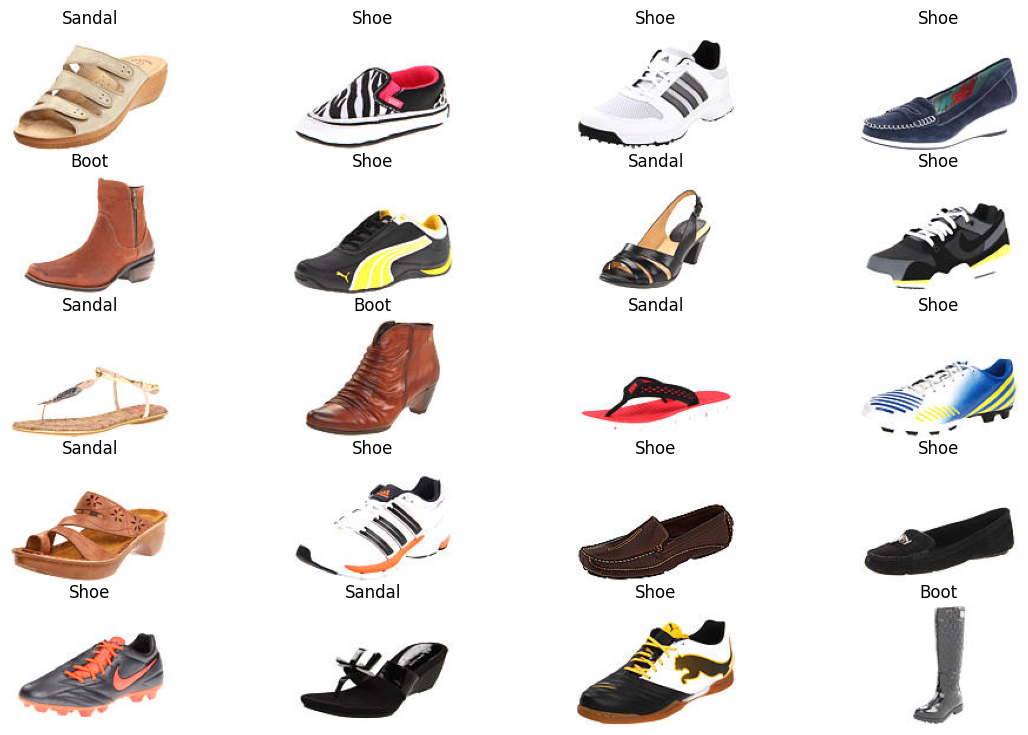

In [7]:
# Show some examples of imgs
fig = plt.figure(figsize = (14, 9))
for i in range(20):
    plt.subplot(5, 4, i+1)
    img = PIL.Image.open(df.loc[i, "paths"])
    plt.imshow(img)
    plt.axis("off")
    plt.title(df.loc[i, "ctg"])
    plt.rcParams["figure.facecolor"] = "white"
    img.close()

In [8]:
batch_size = 32

# Image data augmentation 

In [9]:
data_gen = ImageDataGenerator(
    zoom_range = [0.8, 1.3],
    width_shift_range = 0.2,
    horizontal_flip = True,
    rotation_range = 20,
    validation_split = 0.25
)

In [10]:
# create a train data generator
train_data = data_gen.flow_from_directory(
    "data", 
    target_size=(256, 256), 
    batch_size = batch_size, 
    shuffle = True, 
    class_mode = "binary", 
    subset = "training"
    
)

Found 11250 images belonging to 3 classes.


In [11]:
# create a validation data generator
val_data = data_gen.flow_from_directory(
    "data", 
    target_size=(256, 256), 
    batch_size = batch_size, 
    shuffle = False, 
    class_mode = "binary", 
    subset = "validation"
    
)

Found 3750 images belonging to 3 classes.


In [12]:
def transfer_learn(premade):
    x = GlobalAveragePooling2D()(premade.output)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(3, activation = "softmax")(x)
    return Model(inputs = premade.input, outputs = out)

In [13]:
# load pretrained mobilenet
mobilenet = MobileNetV3Small(
    include_top = False, 
    input_shape = (256, 256, 3),
    weights = "imagenet"
)
mobilenet.trainable = False

2022-10-14 21:13:27.941337: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-10-14 21:13:27.941386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sady
2022-10-14 21:13:27.941395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sady
2022-10-14 21:13:27.941520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.76.0
2022-10-14 21:13:27.941551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-10-14 21:13:27.941560: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.65.1 does not match DSO version 515.76.0 -- cannot find working devices in this configuration
2022-10-14 21:13:27.941952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary 

In [14]:
# get our final model
model1 = transfer_learn(mobilenet)

In [15]:
epochs = 100


In [16]:
model1.compile(
    optimizer = Adam(learning_rate = 0.001), 
    loss = SparseCategoricalCrossentropy(from_logits = False),
    metrics=["accuracy"]
)

In [17]:
callbacks = [EarlyStopping(monitor = "val_accuracy", patience = 2, min_delta = 0.01), 
             ModelCheckpoint("mobnet", monitor = "val_accuracy")]

In [18]:
# Train it
history = model1.fit(
    train_data, 
    validation_data = val_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/100
352/352 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9043

INFO:tensorflow:Assets written to: mobnet/assets


INFO:tensorflow:Assets written to: mobnet/assets


352/352 [==============================] - 223s 625ms/step - loss: 0.2446 - accuracy: 0.9043 - val_loss: 0.1361 - val_accuracy: 0.9507
Epoch 2/100
352/352 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9460

INFO:tensorflow:Assets written to: mobnet/assets


INFO:tensorflow:Assets written to: mobnet/assets


352/352 [==============================] - 226s 641ms/step - loss: 0.1505 - accuracy: 0.9460 - val_loss: 0.1315 - val_accuracy: 0.9475
Epoch 3/100
352/352 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9534

INFO:tensorflow:Assets written to: mobnet/assets


INFO:tensorflow:Assets written to: mobnet/assets


352/352 [==============================] - 224s 636ms/step - loss: 0.1298 - accuracy: 0.9534 - val_loss: 0.1800 - val_accuracy: 0.9395


## Evaluate model 

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
y_pred = model1.predict(val_data, 32)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

118/118 [==============================] - 54s 450ms/step


array([0, 0, 0, ..., 2, 2, 2])

In [21]:
y_true = val_data.classes
y_true

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [22]:
lbls = val_data.class_indices.keys()

In [23]:
cm = confusion_matrix(y_true, y_pred, normalize = "true")

In [24]:
cm

array([[0.8768, 0.0456, 0.0776],
       [0.0024, 0.972 , 0.0256],
       [0.0016, 0.04  , 0.9584]])

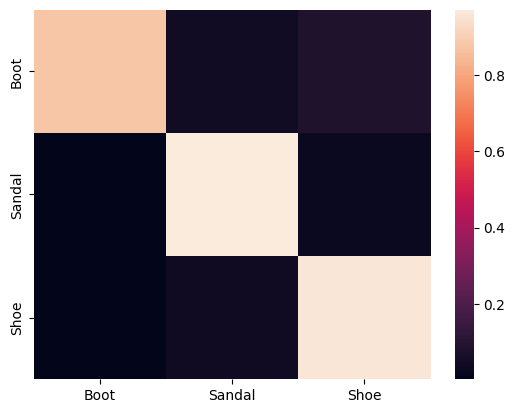

In [25]:
lbls = val_data.class_indices.keys()
seaborn.heatmap(cm, xticklabels = lbls, yticklabels=lbls)
plt.show()

In [26]:
val_data.class_indices

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

In [27]:
print(
    classification_report(y_true, y_pred, target_names = val_data.class_indices.keys())
)

              precision    recall  f1-score   support

        Boot       1.00      0.88      0.93      1250
      Sandal       0.92      0.97      0.94      1250
        Shoe       0.90      0.96      0.93      1250

    accuracy                           0.94      3750
   macro avg       0.94      0.94      0.94      3750
weighted avg       0.94      0.94      0.94      3750

